In [1]:
#!pip install -r requirements.txt Uncomment and run this for installing all required packages

All the Insights are marked under **Takeaway Section** after each analysis

In [2]:
# Developer: Ayush Oturkar
# Date: May 27, 2023
# EG Game Analysis


#LOADING REQUIRED LIBRARIES
#Data Visualization libraries
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import accuracy_score
import shap
import pickle
from pycaret.classification import *
from imblearn.over_sampling import SMOTE

#Importing train, test split library
from sklearn.model_selection import train_test_split

%matplotlib inline

#For proper display of all columns
from IPython.display import display
pd.options.display.max_columns = None

#Import warnings
import warnings
warnings.filterwarnings("ignore")

# Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import confusion_matrix

import configparser
import optuna

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import time
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the config.ini file
config.read(os.path.join(os.getcwd(), "config", "config.ini"))

# Access values from the config.ini file
root_path = config.get("code_path", "root_path")
data_folder = config.get("code_path", "data_folder")
data_file_name = config.get("code_path", "data_file_name")

# Load model
load_trained_model = bool(config.get("model", "load_trained_model"))

# Data Loading

In [5]:
# Lets look at the snapshot of the dataset quickly.
gamedf = pd.read_csv(os.path.join(root_path, data_folder, data_file_name))
gamedf.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


Lets have a quick look on the data type to check if any feature is misclassified as on "Object"

# Data Preprocessing

In [6]:
# Lets see if there is any categorical feature and look at its statistics
display(gamedf.describe(include=["O"]))

,Age,HoursPerWeek,TotalHours
count,3395,3395,3395
unique,29,33,238
top,20,10,500
freq,357,411,328


**Takeaway:**

**Age, HourPerWeek, TotalHours should be numeric data dtype**. Being an object data type implies that something might be wrong is what we can suspect. Some unwanted characters might be in there is our hypothesis. 

Lets look the unique values of Age, HoursPerWeek, TotalHours and see if we can detect any anomoly.

In [7]:
gamedf["Age"].unique()

array(['27', '23', '30', '19', '32', '21', '17', '20', '18', '16', '26',
       '38', '28', '25', '22', '29', '24', '35', '31', '33', '37', '40',
       '34', '43', '41', '36', '44', '39', '?'], dtype=object)

In [8]:
gamedf["HoursPerWeek"].unique()

array(['10', '20', '6', '8', '42', '14', '24', '16', '4', '12', '30',
       '28', '70', '2', '56', '36', '40', '18', '96', '50', '168', '48',
       '84', '0', '72', '112', '90', '32', '98', '140', '?', '80', '60'],
      dtype=object)

In [9]:
gamedf["TotalHours"].unique()

array(['3000', '5000', '200', '400', '500', '70', '240', '10000', '2708',
       '800', '6000', '190', '350', '1000', '1500', '2000', '120', '1100',
       '2520', '700', '160', '150', '250', '730', '230', '300', '100',
       '270', '1200', '30', '600', '540', '280', '1600', '50', '140',
       '900', '550', '625', '1300', '450', '750', '612', '180', '770',
       '720', '415', '1800', '2200', '480', '430', '639', '360', '1250',
       '365', '650', '233', '416', '1825', '780', '1260', '315', '10',
       '312', '110', '1700', '92', '2500', '1400', '220', '999', '303',
       '96', '184', '4000', '420', '60', '2400', '2160', '80', '25',
       '624', '176', '?', '35', '1163', '333', '75', '7', '40', '325',
       '90', '175', '88', '850', '26', '1650', '465', '235', '1350',
       '460', '848', '256', '130', '1466', '670', '711', '1030', '1080',
       '1460', '1050', '20000', '582', '2800', '553', '1008', '330',
       '936', '243', '1320', '425', '1145', '366', '2700', '830', '3',
 

 ### Takeaway:
 
Clearly we can see that there is **"?"** in the data because of which pandas treats the above three variables as object. These three columns should be treated as numeric for any kind of analysis. Hence we will be converting it back to numeric and replacing "?" will null value and will treat it.

### Cleaning Age, HoursPerWeek and TotalHours variables as below

In [10]:
inval_dtypecol = ["Age", "HoursPerWeek", "TotalHours"]

# Replacing '?' as null value
gamedf[inval_dtypecol] = gamedf[inval_dtypecol].apply(lambda x: x.replace("?", np.nan))

# Converting the dtype of these features to numeric
for col in inval_dtypecol:
    gamedf[col] = pd.to_numeric(gamedf[col])

Lets write a quick missing value datacheck function & check the missing value count:

In [11]:
# Funtion to check the missing value count and percentage
def missing_val_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data


# Converting blank spaces to null to capture the duplicates from our data
gamedf.replace(r"^\s*$", np.nan, regex=True, inplace=True)
missing_val_check(gamedf)

,Total,Percent(%)
TotalHours,57,1.678940
HoursPerWeek,56,1.649485
Age,55,1.620029
GameID,0,0.000000
GapBetweenPACs,0,0.000000
ComplexUnitsMade,0,0.000000
UniqueUnitsMade,0,0.000000
WorkersMade,0,0.000000
TotalMapExplored,0,0.000000
ActionsInPAC,0,0.000000


We can see that Age, TotalHours and HoursperWeek are missing and roughly 1% of the data is missing, which can be simply imputed. Lets fix the missing values of Age, Hoursperweek and TotalHours by imuputing them intelligently.

In [12]:
gamedf[gamedf["Age"].isnull()].head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3340,10001,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.0
3341,10005,8,NaN,NaN,NaN,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.0
3342,10006,8,NaN,NaN,NaN,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.0
3343,10015,8,NaN,NaN,NaN,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.0
3344,10016,8,NaN,NaN,NaN,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.0


Looks like the missing value for Age corresponds to leagueindex = 8. Lets confirm

In [13]:
print(
    "Total missing values for LeagueIndex = 8 and Age as null value:",
    gamedf[(gamedf["LeagueIndex"] == 8) & (gamedf["Age"].isnull())].shape[0],
)

Total missing values for LeagueIndex = 8 and Age as null value: 55


### Takeaway:

1. All the missing value corresponding to Age, belongs to LeagueIndex = 8
2. Lets look at the distribution of Age by leagueIndex so that we can impute the missing value with median value of leagueIndex = 7

<AxesSubplot:xlabel='LeagueIndex', ylabel='Age'>

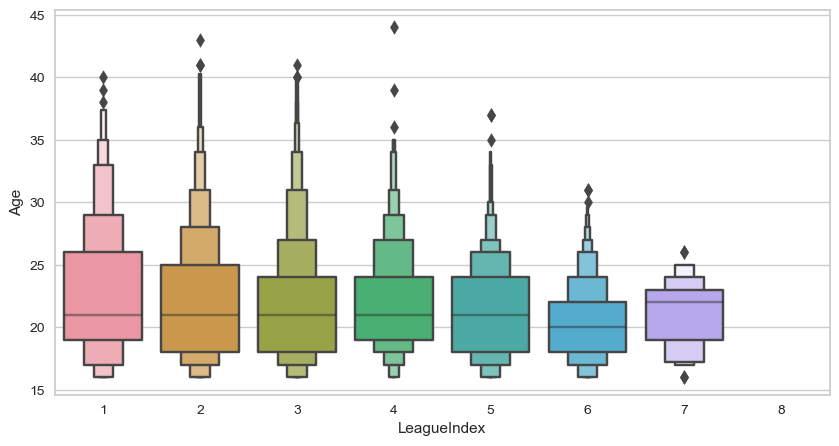

In [14]:
# Can also be taken as part of task 2 in the code below
plt.figure(figsize=(10, 5))
sns.boxenplot(data=gamedf, x="LeagueIndex", y="Age", k_depth="trustworthy")

**Takeaway:**

Clearly we can see in the higher league index we have more younger players which is kindoff understandable as young players tend to have higher stamina, reflexes and muscle memory for gaming as compared to the senior level players. Hence its an better idea to replace the age group of league index as median of 7.

In [15]:
med_val = gamedf[gamedf["LeagueIndex"] == 7]["Age"].median()
gamedf["Age"] = gamedf["Age"].fillna(med_val)

Let now check the distribution of hoursperweek for different leagueindex

<AxesSubplot:xlabel='LeagueIndex', ylabel='HoursPerWeek'>

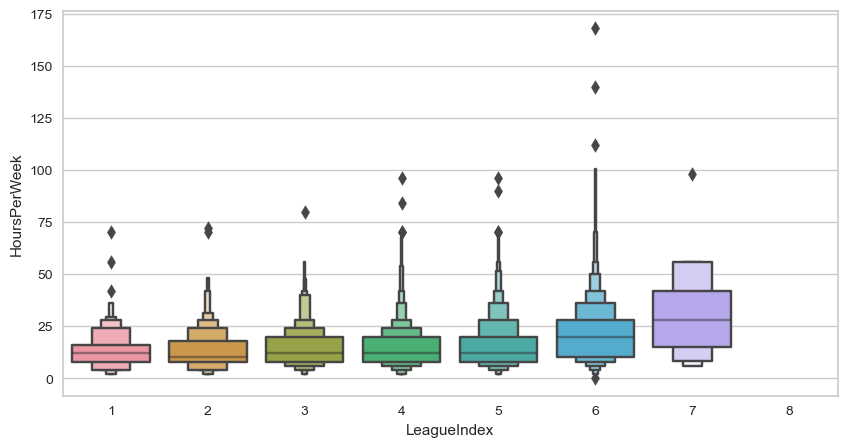

In [16]:
# Can also be taken as part of task 2 in the code below
plt.figure(figsize=(10, 5))
sns.boxenplot(data=gamedf, x="LeagueIndex", y="HoursPerWeek", k_depth="trustworthy")

### Takeaway:

Highly league player tends to spend more time playing. Hence we take roughly the same value as the median value of leagueindex =7 for imputing the missing value for HoursPerWeek.

In [17]:
gamedf[gamedf["HoursPerWeek"].isnull()]["LeagueIndex"].unique()

array([5, 8])

As there is one extra missing value of hoursperweek for a player with LeagueIndex. Imputing this with median of hourspweweek of players in leagueindex=5

**Imputing missing value for HoursPerWeek**

In [18]:
# First imputing the missing value for player with missing hoursperweek for leagueindex = 5
med_val_l5 = gamedf[gamedf["LeagueIndex"] == 5]["HoursPerWeek"].median()
gamedf.loc[
    (gamedf["HoursPerWeek"].isnull()) & (gamedf["LeagueIndex"] == 5), "HoursPerWeek"
] = med_val_l5

# Now imputing the missing value for player with missing hoursperweek for leagueindex = 8
med_val_l8 = gamedf[gamedf["LeagueIndex"] == 7]["HoursPerWeek"].median()
gamedf.loc[
    (gamedf["HoursPerWeek"].isnull()) & (gamedf["LeagueIndex"] == 8), "HoursPerWeek"
] = med_val_l8

Now lets look at **Total Hours** trend:

<AxesSubplot:xlabel='LeagueIndex', ylabel='TotalHours'>

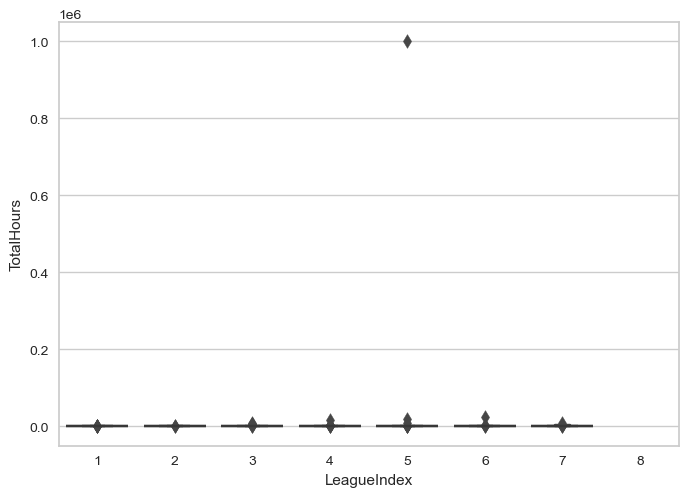

In [19]:
sns.boxenplot(data=gamedf, x="LeagueIndex", y="TotalHours", k_depth="trustworthy")

As we cant any significant trend in this. Lets impute the missing value of totalhours by taking median value of players in the league 5, 6 and 7. But lets check the player leagueindex with missing total hours other than leagueindex = 8

In [20]:
gamedf[gamedf["TotalHours"].isnull()]["LeagueIndex"].unique()

array([5, 8])

Now we can impute the missing values as median of total hours from league 5,6,7

**Imputing missing value for TotalHours**

In [21]:
med_val_l6l7 = gamedf[gamedf["LeagueIndex"].between(5, 7)]["TotalHours"].median()
gamedf.loc[gamedf["TotalHours"].isnull(), "TotalHours"] = med_val_l6l7
print("Total missing values now are {}".format(gamedf.isnull().sum().sum()))

Total missing values now are 0


**Missing values treated successfully**

# Data Cleaning

In [22]:
# Now Lets look at the data statistics
gamedf.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4805.012371,4.184094,21.653608,16.105449,956.553166,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,2719.944851,1.517327,4.172356,11.961811,17172.120355,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2464.500000,3.000000,19.000000,8.000000,300.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4874.000000,4.000000,21.000000,12.000000,500.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,7108.500000,5.000000,24.000000,20.000000,800.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
max,10095.000000,8.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001752,10.000000,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


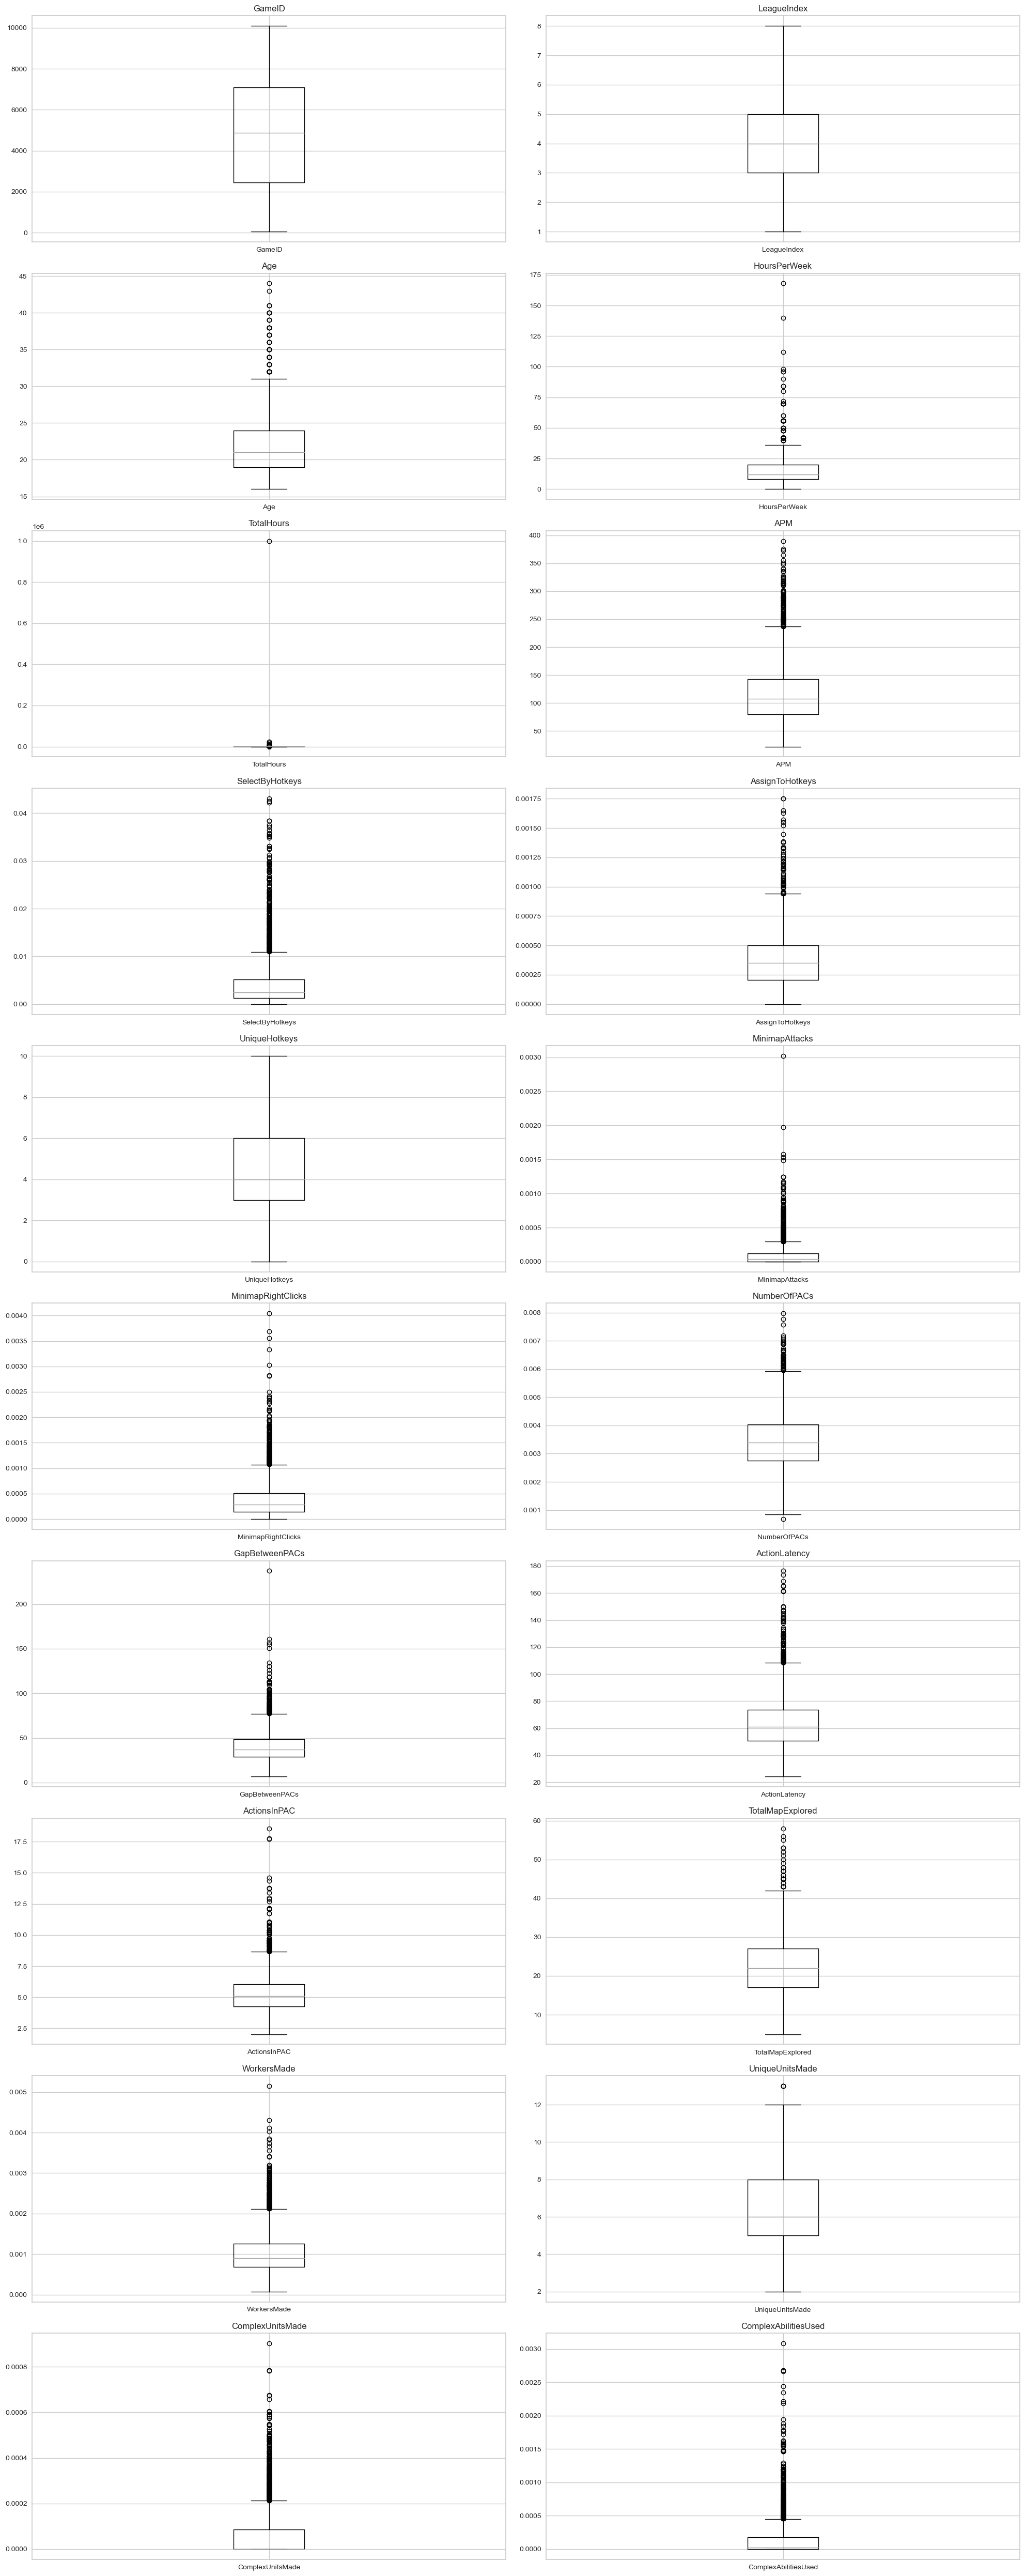

In [23]:
# Determine the number of rows and columns for the subplot grid
num_features = len(gamedf.columns)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_features + num_cols - 1) // num_cols  # Round up division for the number of rows

# Calculate the figure size based on the desired size of individual box plots
fig_width = 10 * num_cols
fig_height = 5 * num_rows

# Create the subplot grid with the updated figsize
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Flatten the axes to simplify indexing
axes = axes.flatten()

# Iterate over the columns and plot the boxplots
for i, column in enumerate(gamedf.columns):
    ax = axes[i]
    gamedf.boxplot(column=column, ax=ax)
    ax.set_title(column)

# Hide any unused subplots
if num_features < num_rows * num_cols:
    for j in range(num_features, num_rows * num_cols):
        fig.delaxes(axes[j])

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()


In [24]:
print(
    "On average total hours a player can play considering 20 years of period",
    gamedf["HoursPerWeek"].median() * 52 * 20,
)

On average total hours a player can play considering 20 years of period 12480.0


### Takeaways

1) Clearly we can identify few outliers in the data. Some can be genuine & some might be incorrectly entered into the system. Outlier treatment is a crucial step. We need to verify with business before taking any call. If there is some value which is impossible can be treated directly.

2) For example if we look closely at HoursPerWeek the outlier value is 168 which is equal to 24 * 7 i.e. 168. This is impossible that any player can play 24 hours, 7 days a week. A player will atleast take 2 hours break in a day (my assumption). Hence we will replace all the values >154 as 154.

3) Next if we look at TotalHours which comes out to be 1000000 hours. This also clearly looks like an anomoly. As we saw in the last code 12480 is the average total hour a player can be assumed to play, however some players can play long hours for a long time. Hence keeping this in mind and keeping a reasonable leeway, we can just replace the values greater than 25000 hours to 25000. Again this should be confirmed with a massive dataset of players histories of total hours played so that we pass nearly correct value for our model for better fit.

4) Rest some other feetures are players attributes which are having outliers which is possible given some players are really good in their reflexes and other abilities, unless we verify it with some scientific fact to report any anomoly entry for treatment.

5) We can also notice that minimum value of ComplexUnitsMade and ComplexAbilitiesUsed have 0 as minimum value which can be highlighting point. But again this maybe possible during a game so I am keeping this as it is for now. In really life we need to check from business if a 0 value is possible.

## Outlier Treatment

In [25]:
# 1. Replacing the hoursperweek values with values greater than 154 as 154
gamedf.loc[gamedf["HoursPerWeek"] > 154, "HoursPerWeek"] = 154

# 2. Replacing anomolous Total hours as mentioned in the takeaway above
gamedf.loc[gamedf["TotalHours"] > 25000, "TotalHours"] = 25000

## Multicollinearity Check

Multicollinearity has a negative impact on many popular ML models. Check if this dataset
experiences any multicollinearity. Although non-linear boosting, bagging model are resistent to non-collineariy in the data. But we will still try to reduce the multicollinearity to an acceptable point.

<AxesSubplot:>

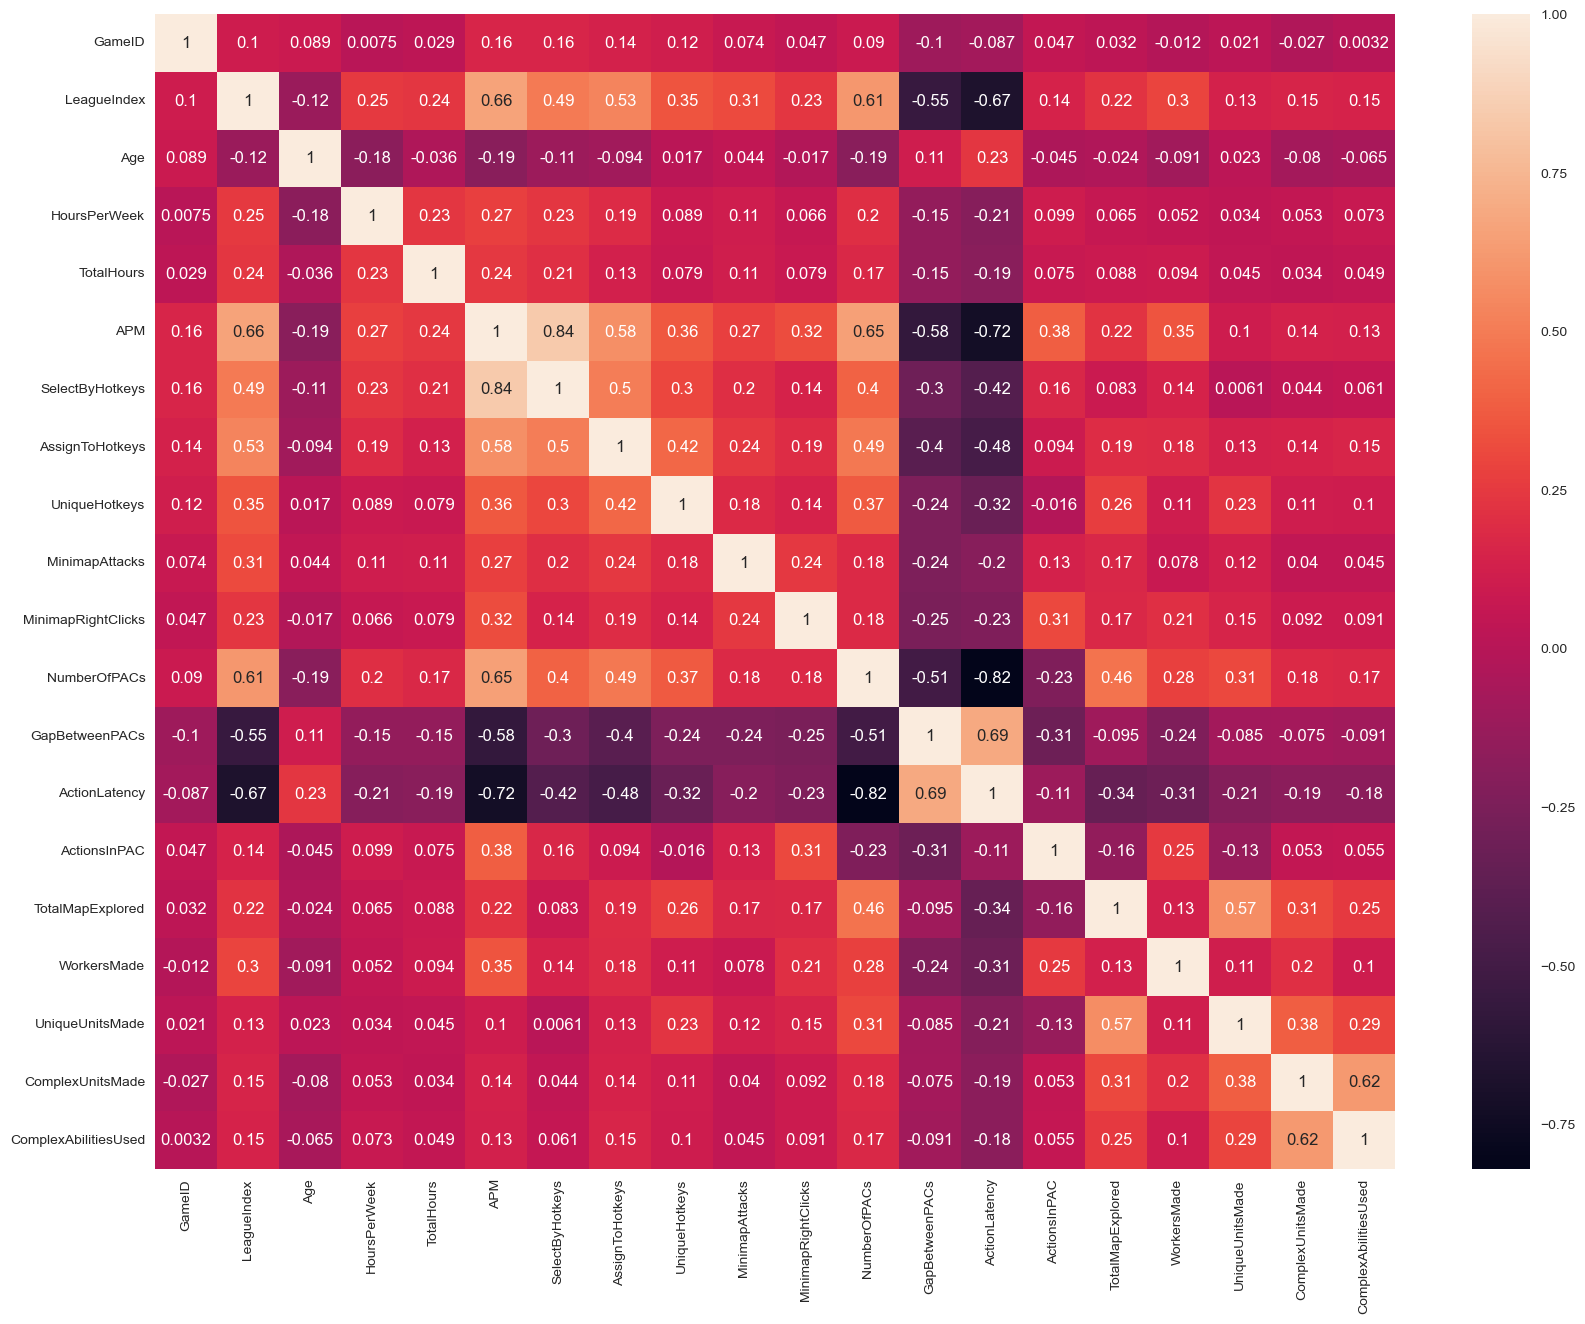

In [26]:
# Lets plot the correlation heatmap to have a rough idea of collinearity between features
plt.figure(figsize=(20, 15))
corr = gamedf.corr()
sns.heatmap(corr, annot=True)

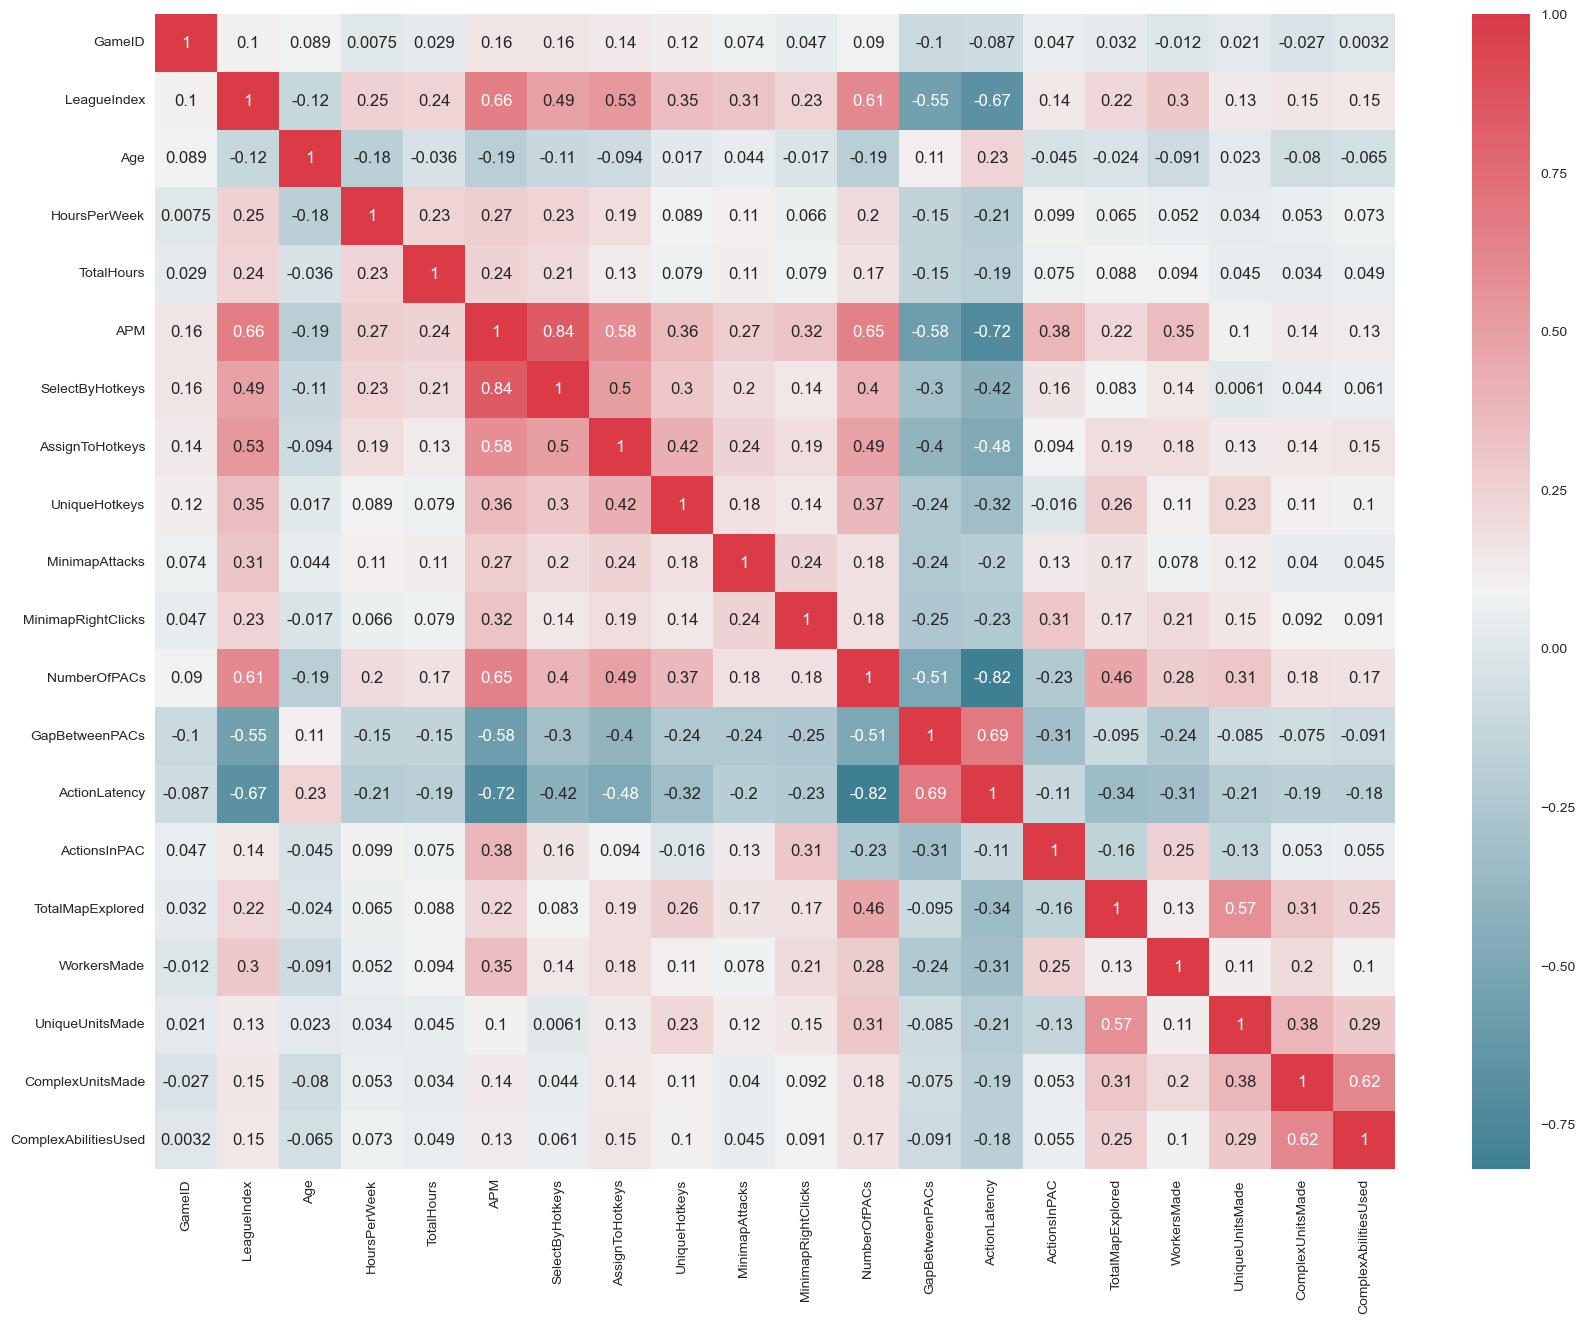

In [27]:
plt.figure(figsize=(20, 15))
corr = gamedf.corr()

# Define a custom colormap with distinct colors for positive and negative correlations
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation heatmap with the custom colormap and colorbar legend
sns.heatmap(corr, annot=True, cmap=cmap, cbar=True)

# Display the plot
plt.show()

### Takeaway

We can clearly see the presence of high correlation between different features. As a rule of thumb any correlation value greater than 0.5 or less than -0.5 is considered as high. Leaving our target i.e. LeagueIndex we can clearly see that **multicollinearity exists**. 

We can print the VIF scores for all the features except the target feature to get better idea.

A variance inflation factor (VIF) provides a measure of multicollinearity among the independent variables in a multiple regression model.

In [28]:
gamedf_indpt = gamedf.drop(["LeagueIndex"], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = gamedf_indpt.columns

# calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(gamedf_indpt.values, i)
    for i in range(len(gamedf_indpt.columns))
]

# Print the VIF
vif_data.sort_values(["VIF"], ascending=False)

,feature,VIF
4,APM,232.216165
10,NumberOfPACs,87.045480
13,ActionsInPAC,68.402738
12,ActionLatency,40.428892
1,Age,29.901522
5,SelectByHotkeys,23.242555
16,UniqueUnitsMade,22.065289
14,TotalMapExplored,18.188792
11,GapBetweenPACs,14.809681
6,AssignToHotkeys,6.506955


### Action taken to remove multicollinearity
We need to see if we can remove multicollinear features without losing any useful information for our future modelling process. 
We can experimentally try :

**Action 1:** Removing **UniqueUnitsMade** as we can see in the heatmap above this feature is weakly correlated with our target but has high VIF also highly correlated with **TotalMapsExplored**. Also we can remove **SelectByHotkeys** as this is highly correlated with **AssignToHotkeys** where AssignToHotkeys is better correlated with our target.

**Action 2:** Also we can remove **APM** as this is clearly highly correlated with **ActionLatency** and ActionLatency is slighly more correlated to our target. Also APM have significantly high VIF value

**Action 3** We clearly see now that **NumberOfPACs** is highly correlated to **ActionLatency**. Also **GapBetweenPACs** is highly correlated with **NumberOfPACs**. Also TotalMapExplored is highly correlated with **Action Latency and ComplexUnitsMade**. Hence we remove **NumberofPACs, GapBetweenPACs , TotalMapExplored  and recheck our VIF scores**

In [29]:
# Action 2
gamedf_indpt = gamedf.drop(
    [
        "LeagueIndex",
        "UniqueUnitsMade",
        "SelectByHotkeys",
        "APM",
        "NumberOfPACs",
        "TotalMapExplored",
        "GapBetweenPACs",
    ],
    axis=1,
)
vif_data = pd.DataFrame()
vif_data["feature"] = gamedf_indpt.columns

# calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(gamedf_indpt.values, i)
    for i in range(len(gamedf_indpt.columns))
]
vif_data.sort_values(["VIF"], ascending=False)

,feature,VIF
1,Age,22.758171
9,ActionsInPAC,13.955593
8,ActionLatency,13.178095
10,WorkersMade,5.607455
5,UniqueHotkeys,5.432839
4,AssignToHotkeys,5.302117
0,GameID,4.226146
2,HoursPerWeek,3.028065
7,MinimapRightClicks,2.493986
11,ComplexUnitsMade,2.156833


### Takeaway:

We can see that we were able to significanly remove multicollinearity in the data however Age vif is still on the higher side.

**Action 4:** Still I was hoping that above mentioned steps would solve out problem of multicollinearity. Here we can still see that still Age having high VIF factor. As most of the variance from Age variable is explained by other features, we can remove Age without losing significant information for our model or we can creates bucketing of these feature. Like Age16-Age20, Age 20-Age 25, Age 25 - Age 30 and so on.

I am keeping this feature for now for further analysis of the data.

In [30]:
# Game df after removing highly collinear feature set

# Lets plot the correlation heatmap to have a rough idea of collinearity between features
col_to_drop = [
    "UniqueUnitsMade",
    "SelectByHotkeys",
    "APM",
    "NumberOfPACs",
    "TotalMapExplored",
    "GapBetweenPACs",
]
gamedf.drop(col_to_drop, axis=1, inplace=True)

# EDA

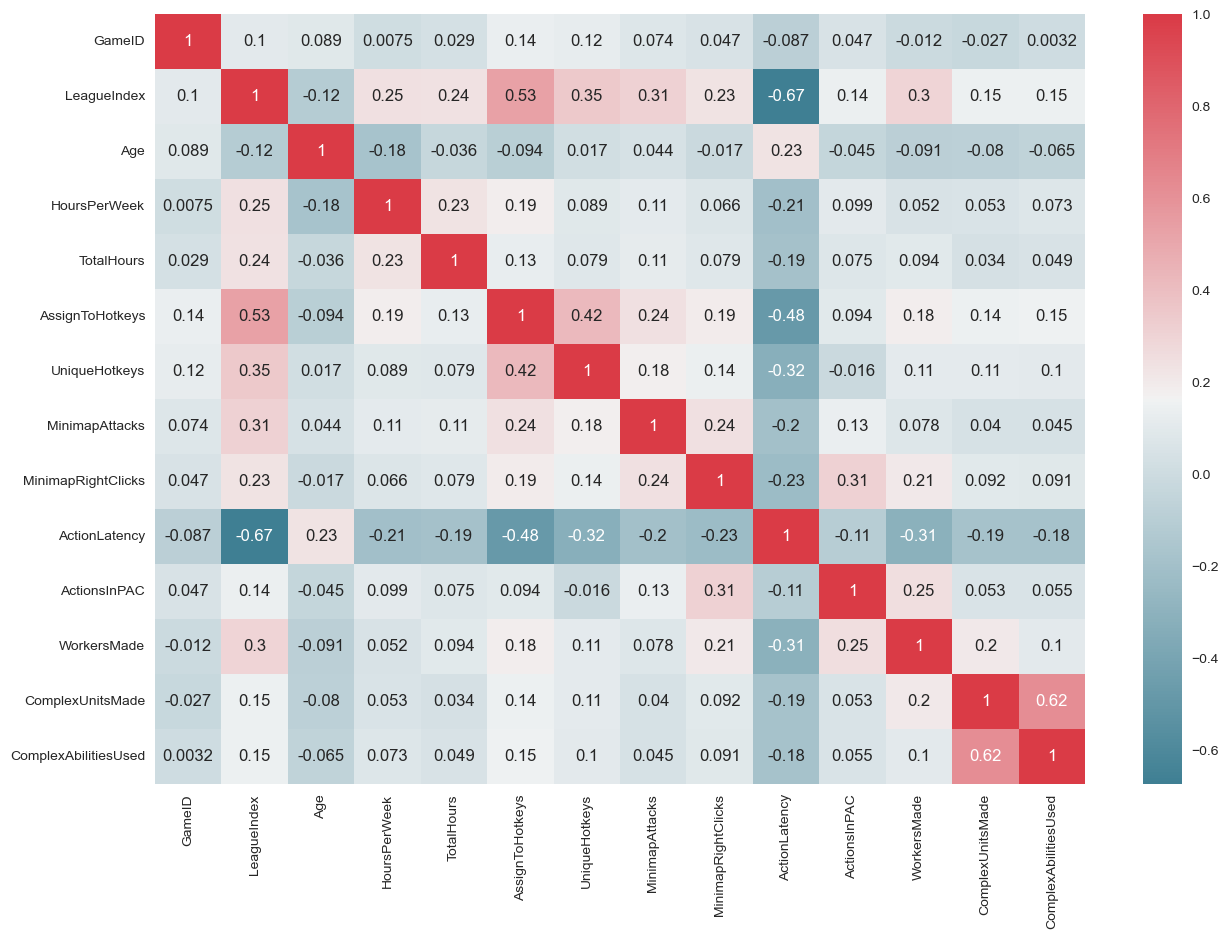

In [31]:
plt.figure(figsize=(15, 10))
corr = gamedf.corr()

# Define a custom colormap with distinct colors for positive and negative correlations
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation heatmap with the custom colormap and colorbar legend
sns.heatmap(corr, annot=True, cmap=cmap, cbar=True)

# Display the plot
plt.show()

**Initial Hypothesis:**

abs(corr)>=0.3 is considered as significant correlation between different features.


From the above correlation heatmap we can draw some hypothesis:

1. Action latency significantly seems to have significant negetive correlation with our target variable. This is kind of very obvious that lower the action latency a player has, the better the player is and better the chances to be playing in higer leagues.


2. Total hours/ hours per week seems to have decent correlation value with our target. The hypothesis here is that more practise a player does, the better he performs in the leagues and has more chances to be in the higher leagues. Although its alone not significant.


3. AssignToHotKeys have a correlation value of 0.53 with the target. This implies that plyer having higher number of units or buildings assigned to hotkeys per timestamp have better chances to play in the higer leagues.


4. Minimapattacks, WorkersMade also have high correlation hence can be an important predictor for our target

Lets perform some EDA to have test our hypothesis:

Text(0, 0.5, 'ActionLatency')

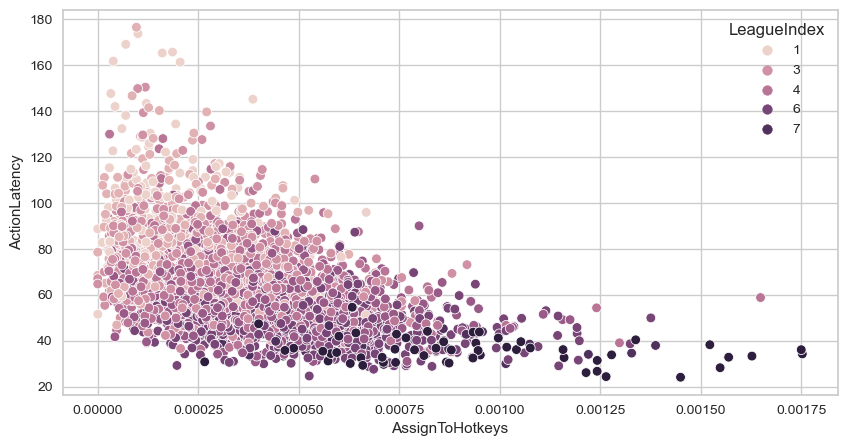

In [32]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=gamedf, x="AssignToHotkeys", y="ActionLatency", hue="LeagueIndex")
plt.xlabel("AssignToHotkeys")
plt.ylabel("ActionLatency")

### Takeaway: 

We can see that players with higher number of units or buildings assigned to hotkeys per timestamp and lower action latency seems to perform better and belong to higer leagues and vice versa. Hence this features are important predictors

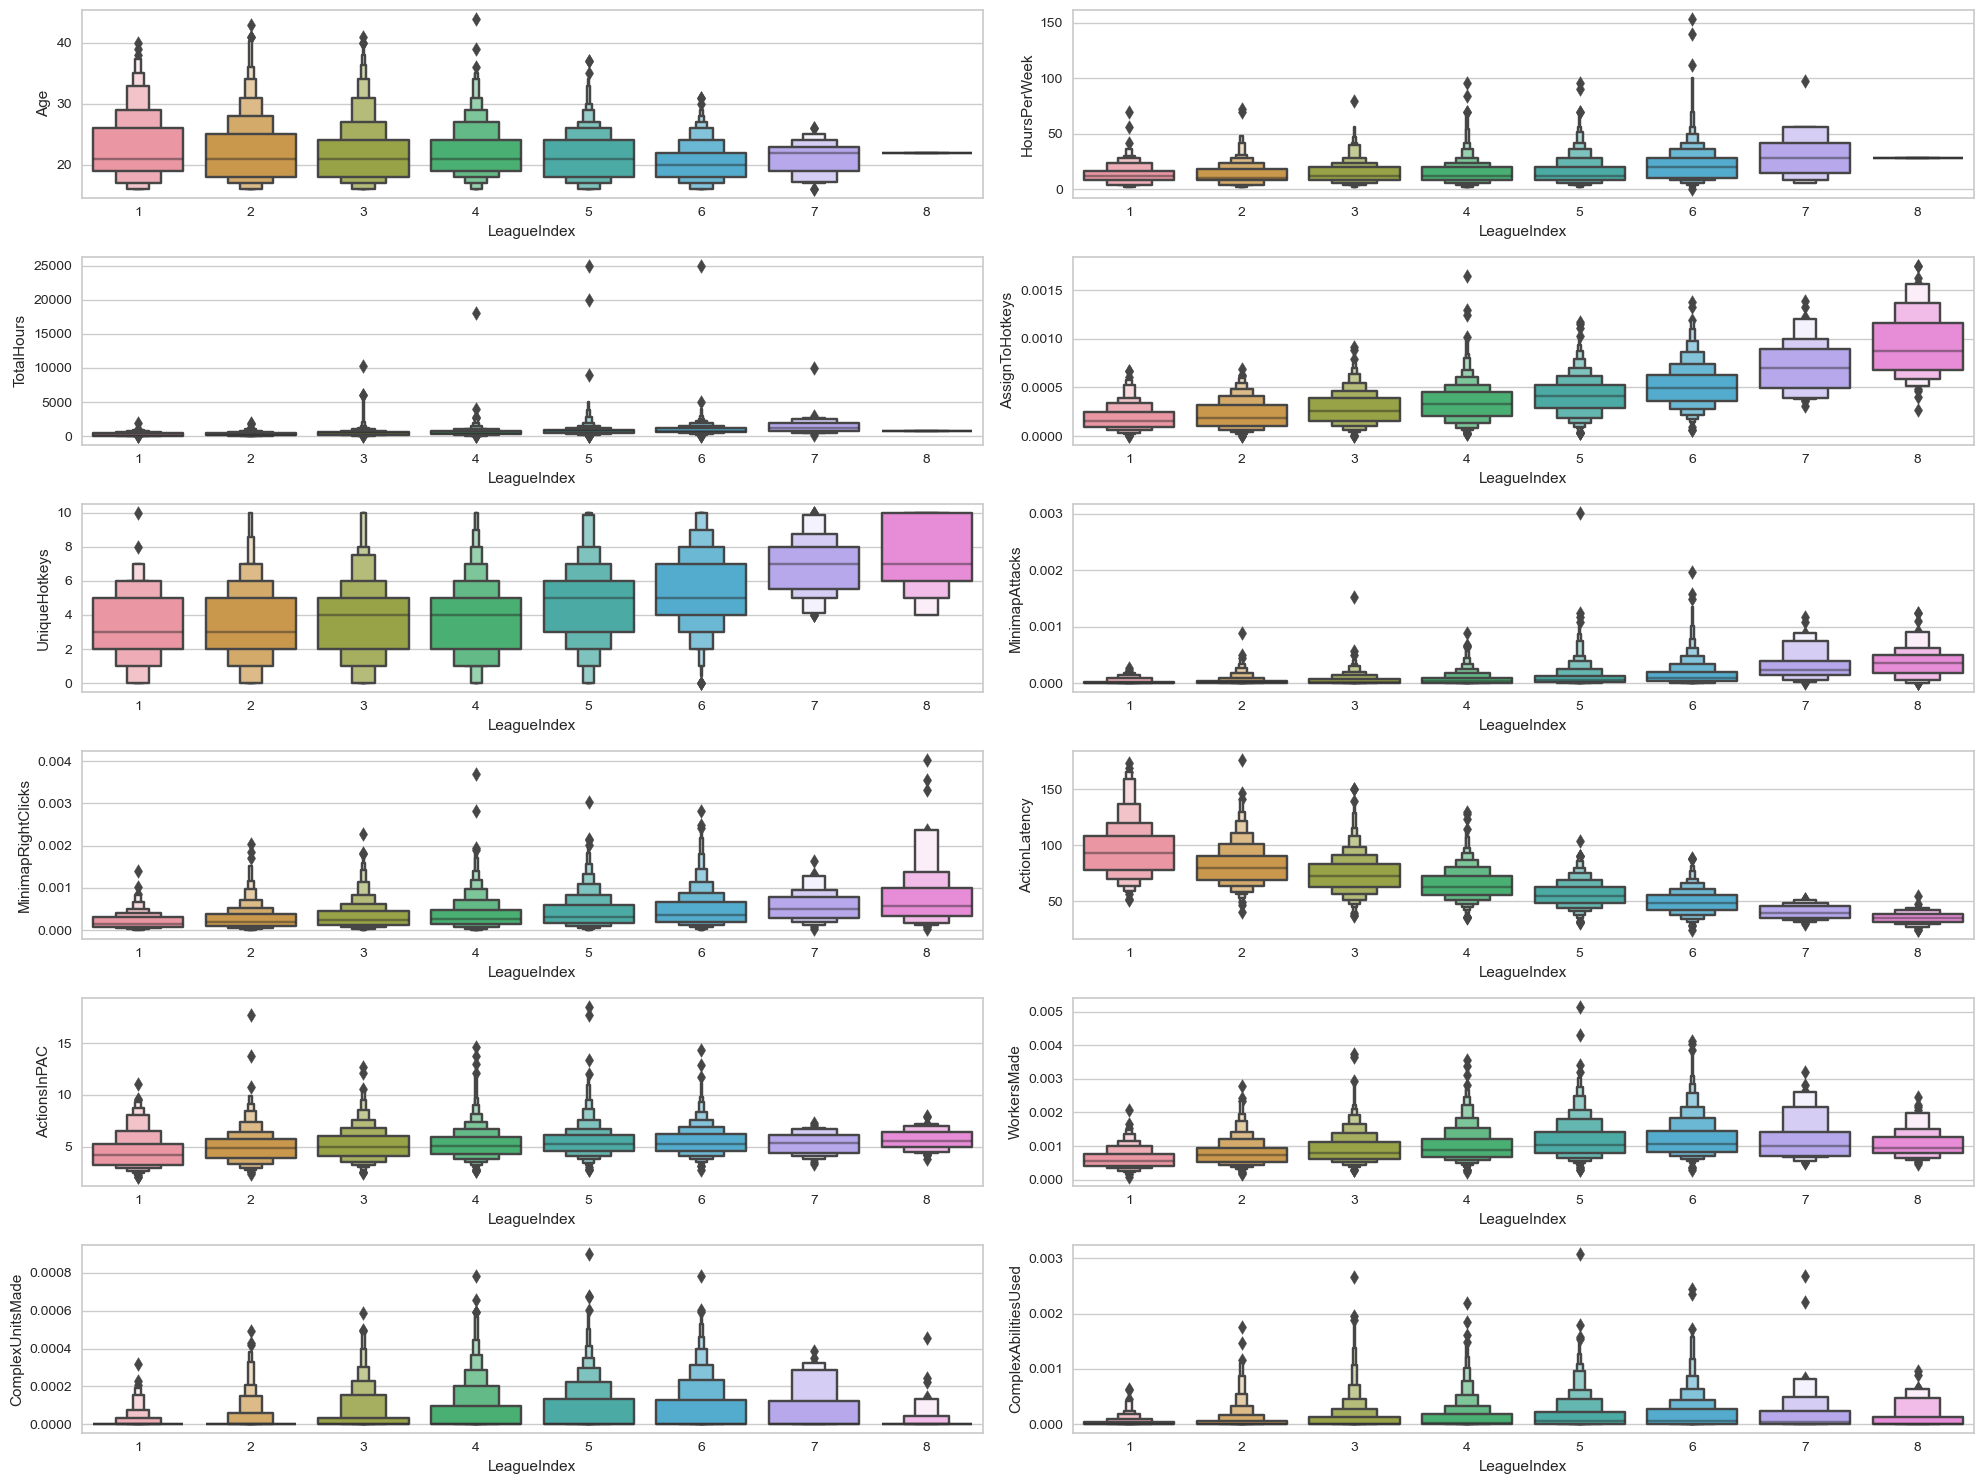

In [33]:
plt.figure(figsize=(20, 15))  # Adjust the figsize if needed

# Define the list of variables to plot
variables = list(gamedf.columns)
variables.remove("LeagueIndex")
variables.remove("GameID")

# Calculate the number of rows and columns for subplots
num_plots = len(variables)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots for each variable
for i, variable in enumerate(variables, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxenplot(data=gamedf, x="LeagueIndex", y=variable, k_depth="trustworthy")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

<AxesSubplot:xlabel='WorkersMade', ylabel='Density'>

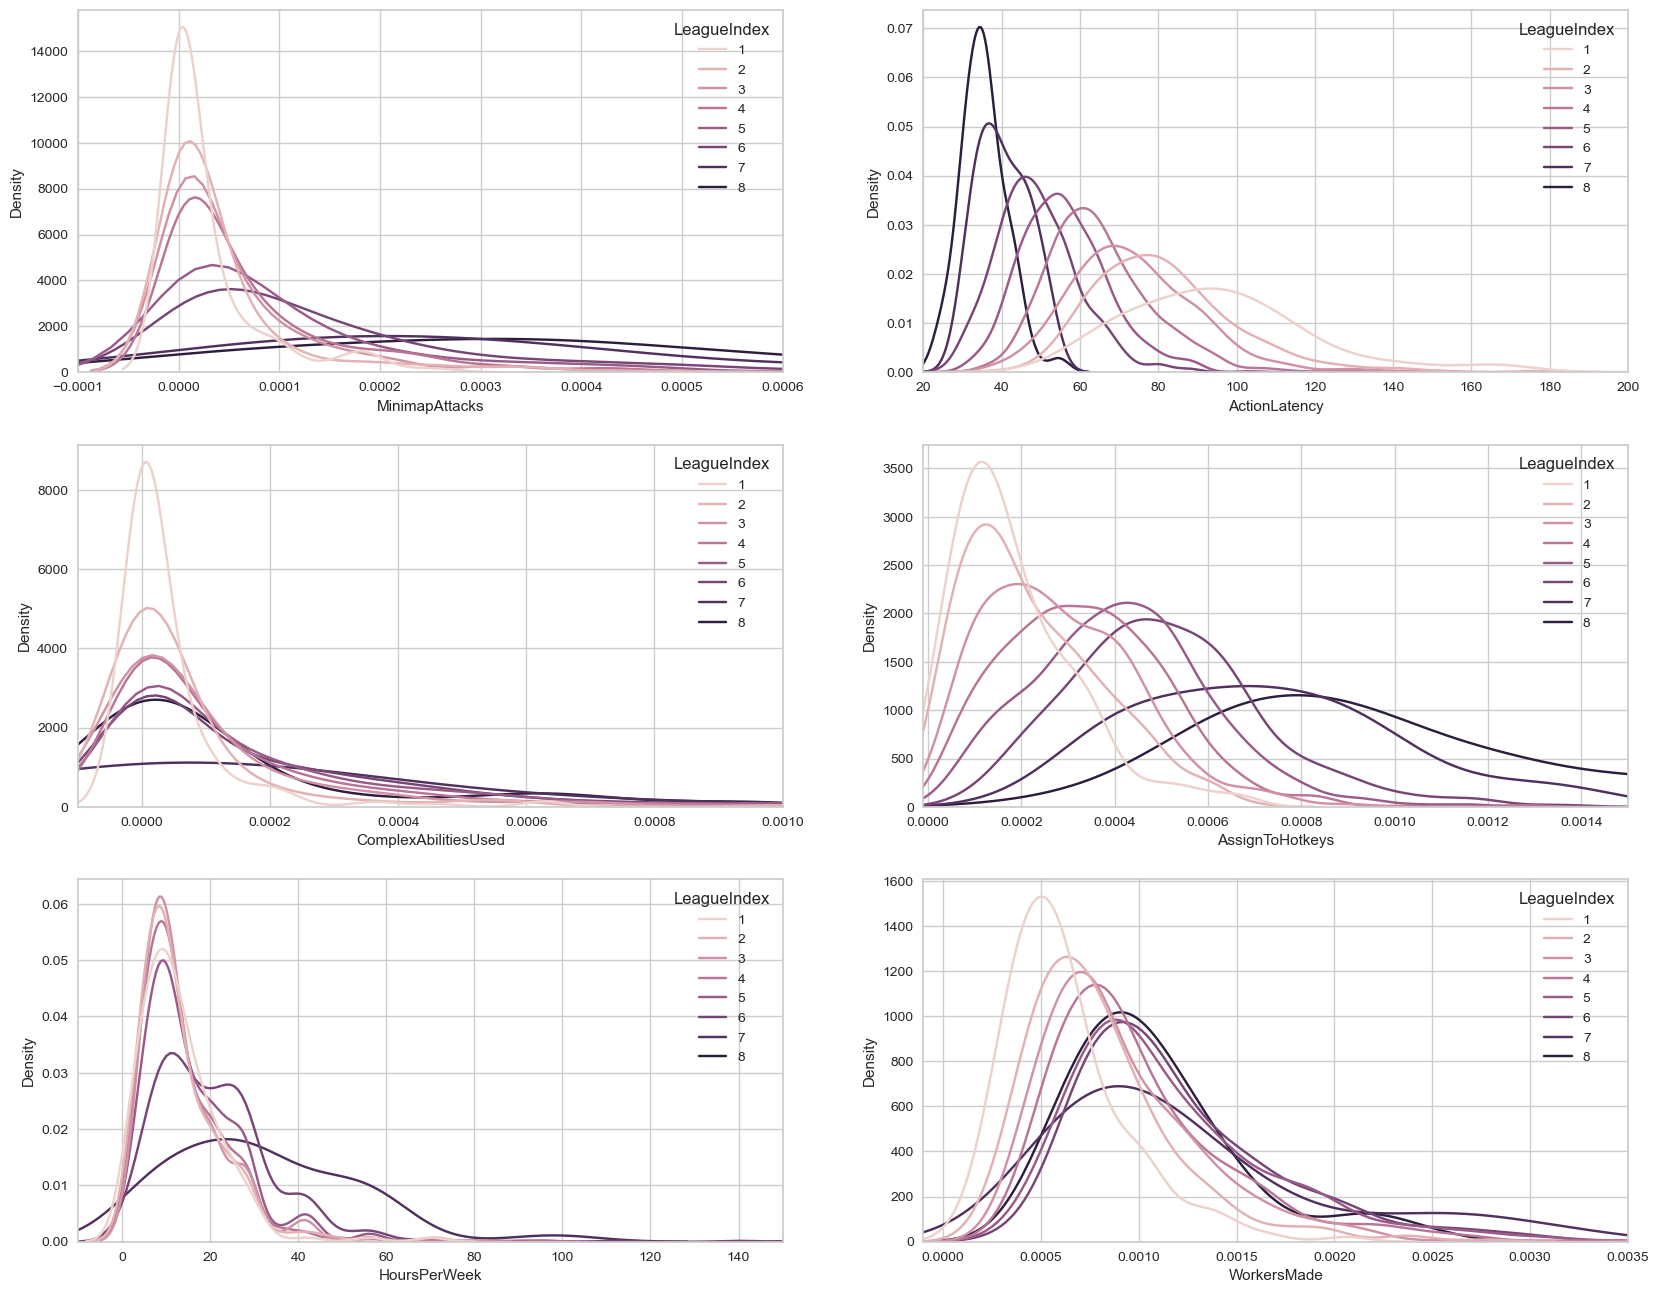

In [34]:
# plot other features with large league placement variation
fig, axes = plt.subplots(3, 2, figsize=(20, 16))
axes[0, 0].set_xlim(-0.0001, 0.0006)
sns.kdeplot(
    ax=axes[0, 0], data=gamedf, x="MinimapAttacks", hue="LeagueIndex", common_norm=False
)
axes[0, 1].set_xlim(20, 200)
sns.kdeplot(
    ax=axes[0, 1], data=gamedf, x="ActionLatency", hue="LeagueIndex", common_norm=False
)
axes[1, 0].set_xlim(-0.0001, 0.001)
sns.kdeplot(
    ax=axes[1, 0],
    data=gamedf,
    x="ComplexAbilitiesUsed",
    hue="LeagueIndex",
    common_norm=False,
)
axes[1, 1].set_xlim(-0.00001, 0.0015)
sns.kdeplot(
    ax=axes[1, 1],
    data=gamedf,
    x="AssignToHotkeys",
    hue="LeagueIndex",
    common_norm=False,
)
axes[2, 0].set_xlim(-10, 150)
sns.kdeplot(
    ax=axes[2, 0], data=gamedf, x="HoursPerWeek", hue="LeagueIndex", common_norm=False
)
axes[2, 1].set_xlim(-0.0001, 0.0035)
sns.kdeplot(
    ax=axes[2, 1], data=gamedf, x="WorkersMade", hue="LeagueIndex", common_norm=False
)

In [35]:
## Key Insights

**Takeaway**

- The widening of distribution functions for higher leagues applies to all roughly to all the features. As you move to higher leagues you find more diversity of players, while for lower leagues most players fall within a narrower band, they are all 'equally' bad. 

- Distribution plots for Minimap Attacks, Select By Hotkeys, Assing To Hotkeys, Workers Made, are similar to APMs. They are probably indicative of important features for determining League placement. 

- Hours per week is similar to the features above, but with much smaller incremental value except for the top leagues. Complex Abilities Used show much less clear league progression than the others, the league averages are increasing a lot less than the widths of their bell shapes.

- League 6 and 7 player trait are very similar this might confuse our model.

# Feature Engineering

**Bucketing Age**

Since Age has high VIF we can bucket this feature to further reduce multicollinearity effect

In [36]:
gamedf["Age_Bucket"] = ""
gamedf.loc[gamedf["Age"].between(16, 20), "Age_Bucket"] = "Age_16_20"
gamedf.loc[gamedf["Age"].between(21, 25), "Age_Bucket"] = "Age_21_25"
gamedf.loc[gamedf["Age"].between(26, 30), "Age_Bucket"] = "Age_26_30"
gamedf.loc[gamedf["Age"].between(31, 35), "Age_Bucket"] = "Age_31_35"
gamedf.loc[gamedf["Age"] > 35, "Age_Bucket"] = "Age_35_plus"

In [37]:
def onehotdataframe(data, cat_cols):
    """
    Creates dummy features for categorical data.
    """
    for c in cat_cols:
        one_hot_col = pd.get_dummies(data[c])
        one_hot_col.columns = [str(col) + "_" + c for col in one_hot_col.columns]
        data = data.drop(c, axis=1)

        # Merging one hot encoded features with our dataset 'data'
        data = pd.concat([data, one_hot_col], axis=1)

    return data

In [38]:
gamedf = onehotdataframe(gamedf, ["Age_Bucket"])

# Modelling

## Modelling using PyCaret

In [41]:
datacp = gamedf.copy().drop(["Age", "GameID"], axis=1)

In [59]:
s = setup(data=datacp, target="LeagueIndex", session_id=1000, use_gpu=False)

,Description,Value
0,Session id,1000
1,Target,LeagueIndex
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7"
4,Original data shape,"(3395, 17)"
5,Transformed data shape,"(3395, 17)"
6,Transformed train set shape,"(2376, 17)"
7,Transformed test set shape,"(1019, 17)"
8,Numeric features,16
9,Preprocess,True


In [60]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.4128,0.7703,0.4128,0.4099,0.4075,0.2690,0.2701,0.0940
gbc,Gradient Boosting Classifier,0.3969,0.7584,0.3969,0.3985,0.3936,0.2520,0.2529,0.4840
lightgbm,Light Gradient Boosting Machine,0.3893,0.7543,0.3893,0.3891,0.3847,0.2410,0.2419,0.1940
lda,Linear Discriminant Analysis,0.3872,0.7558,0.3872,0.3872,0.3778,0.2363,0.2391,0.0360
et,Extra Trees Classifier,0.3867,0.7553,0.3867,0.3879,0.3829,0.2361,0.2370,0.0910
lr,Logistic Regression,0.3821,0.7440,0.3821,0.3823,0.3722,0.2260,0.2284,0.4720
knn,K Neighbors Classifier,0.3510,0.6732,0.3510,0.3545,0.3495,0.2001,0.2007,0.1320
ridge,Ridge Classifier,0.3346,0.0000,0.3346,0.2957,0.2986,0.1512,0.1552,0.0330
dt,Decision Tree Classifier,0.3320,0.5873,0.3320,0.3337,0.3309,0.1793,0.1796,0.0340
nb,Naive Bayes,0.2955,0.6956,0.2955,0.2847,0.2192,0.1408,0.1629,0.1150


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

<AxesSubplot:xlabel='LeagueIndex', ylabel='count'>

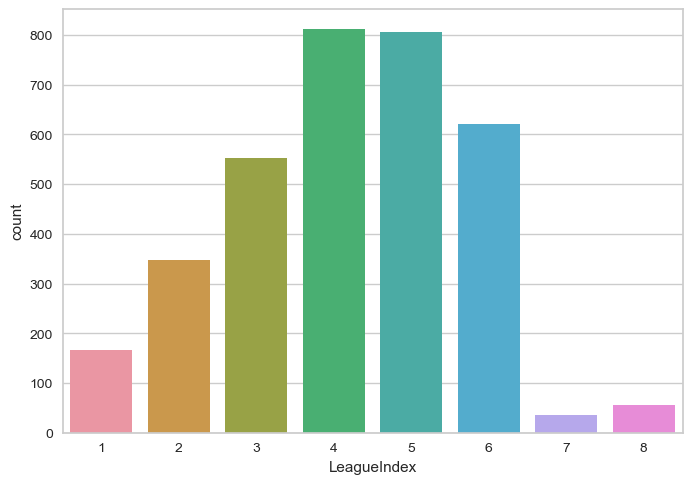

In [61]:
# Explore distribution of target variable
sns.countplot(x="LeagueIndex", data=gamedf)

**-----------------------------------Highly Unbalanced target feature splotted---------------------**

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    datacp.drop(["LeagueIndex"], axis=1),
    datacp["LeagueIndex"],
    test_size=0.2,
    random_state=42,
    stratify=datacp["LeagueIndex"],
)

In [44]:
y_test.value_counts()

4    162
5    161
6    124
3    111
2     70
1     33
8     11
7      7
Name: LeagueIndex, dtype: int64

## Oversampling For Model Performance

In [45]:
# Instantiate the SMOTE oversampler
smote = SMOTE()

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [46]:
list(X_train_resampled.columns)

['HoursPerWeek',
 'TotalHours',
 'AssignToHotkeys',
 'UniqueHotkeys',
 'MinimapAttacks',
 'MinimapRightClicks',
 'ActionLatency',
 'ActionsInPAC',
 'WorkersMade',
 'ComplexUnitsMade',
 'ComplexAbilitiesUsed',
 'Age_16_20_Age_Bucket',
 'Age_21_25_Age_Bucket',
 'Age_26_30_Age_Bucket',
 'Age_31_35_Age_Bucket',
 'Age_35_plus_Age_Bucket']

In [47]:
y_train_resampled.value_counts()

3    649
5    649
4    649
6    649
2    649
8    649
7    649
1    649
Name: LeagueIndex, dtype: int64

In [48]:
train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

In [68]:
s = setup(data=train_resampled, target="LeagueIndex", session_id=1000, use_gpu=False)

,Description,Value
0,Session id,1000
1,Target,LeagueIndex
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7"
4,Original data shape,"(5192, 17)"
5,Transformed data shape,"(5192, 17)"
6,Transformed train set shape,"(3634, 17)"
7,Transformed test set shape,"(1558, 17)"
8,Numeric features,16
9,Preprocess,True


In [69]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6657,0.9276,0.6657,0.6537,0.6570,0.6179,0.6187,0.1140
lightgbm,Light Gradient Boosting Machine,0.6563,0.9236,0.6563,0.6556,0.6546,0.6072,0.6076,0.1720
et,Extra Trees Classifier,0.6340,0.9242,0.6340,0.6268,0.6282,0.5817,0.5824,0.1060
gbc,Gradient Boosting Classifier,0.6018,0.9097,0.6018,0.5961,0.5976,0.5449,0.5454,0.6830
dt,Decision Tree Classifier,0.5751,0.7572,0.5751,0.5691,0.5708,0.5144,0.5149,0.0390
knn,K Neighbors Classifier,0.5743,0.8511,0.5743,0.5605,0.5631,0.5135,0.5148,0.0450
lda,Linear Discriminant Analysis,0.5061,0.8777,0.5061,0.4992,0.4987,0.4355,0.4366,0.0400
nb,Naive Bayes,0.4725,0.8480,0.4725,0.4411,0.4171,0.3971,0.4101,0.0370
lr,Logistic Regression,0.4634,0.8505,0.4634,0.4515,0.4539,0.3867,0.3876,0.1430
ridge,Ridge Classifier,0.4166,0.0000,0.4166,0.3657,0.3348,0.3333,0.3502,0.0370


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

## Hyperparameter Tuning using Optuna

In [49]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 3000, step=50),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"]
        ),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 50,
    }

    # use StratifiedKFold cross-validation with 10 folds
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=50)

    # define F1 score as evaluation metric
    score = make_scorer(f1_score, average="macro")

    start_time = time.time()

    # perform cross-validation and calculate F1 score
    clf = RandomForestClassifier(**params)
    f1_scores = cross_val_score(
        clf, X_train_resampled, y_train_resampled, cv=cv, scoring=score
    )

    elapsed_time = time.time() - start_time

    # return mean F1 score and elapsed time
    return f1_scores.mean()

**Note**

- Model has been trained, tuned and saved as a pkl in model folder
- If retraining is required set load_trained_model to True in config.ini file

In [50]:
if load_trained_model == False:
    # create study object and optimize objective function
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    # print best hyperparameters and best F1 score
    print("Best hyperparameters: ", study.best_params)
    print("Best F1 score: ", study.best_value)

    model = RandomForestClassifier(random_state=50, **study.best_params)
    model.fit(X_train_resampled, y_train_resampled)

else:
    print("Reading Saved model & Training..")
    with open(os.path.join(root_path, "model", "model.pkl"), "rb") as file:
        model = pickle.load(file)
        model.fit(X_train_resampled, y_train_resampled)
        y_pred_test = model.predict(X_test)

Reading Saved model & Training..


**Save Model**

In [109]:
with open(os.path.join(root_path, "model", "model.pkl"), "wb") as file:
    pickle.dump(model, file)

## Model Performance Check

In [51]:
# Creating a funtion to print model performance report on validation and test
def gen_class_report(model, model_name, X_val, y_val, X_test, y_test, val_skip):
    """
    Build a classication model performance report.
    val_skip = True implies skipping performance check on validation and performing check only on test.
    val_skip = False implies checking performance on both validation and test set
    """
    if val_skip == False:
        y_pred_val = model.predict(X_val)
        print(
            "Classification Report for {} model on validation set\n".format(model_name)
        )
        print(classification_report(y_val, y_pred_val))
        print(
            "\n accuracy: {} & F1_Score: {} \n".format(
                accuracy_score(y_val, y_pred_val),
                f1_score(y_val, y_pred_val, average="macro"),
            )
        )
        cm_val = confusion_matrix(y_val, y_pred_val)

        print(
            "Classification Report for {} model on hold out test set\n".format(
                model_name
            )
        )
        y_pred_test = model.predict(X_test)
        print(classification_report(y_test, y_pred_test))
        print(
            "\n accuracy: {} & F1_Score: {} \n".format(
                accuracy_score(y_test, y_pred_test),
                f1_score(y_test, y_pred_test, average="macro"),
            )
        )
        cm_test = confusion_matrix(y_test, y_pred_test)
        print("Confusion matrix on test set : \n")
        sns.heatmap(cm_test, annot=True, fmt="d", cbar=False)
        return cm_val, cm_test
    else:
        print(
            "Classification Report for {} model on hold out test set\n".format(
                model_name
            )
        )
        y_pred_test = model.predict(X_test)
        print(classification_report(y_test, y_pred_test))
        print(
            "\n accuracy: {} & F1_Score: {} \n".format(
                accuracy_score(y_test, y_pred_test),
                f1_score(y_test, y_pred_test, average="macro"),
            )
        )
        cm_test = confusion_matrix(y_test, y_pred_test)
        print("Confusion matrix on test set : \n")
        sns.heatmap(cm_test, annot=True, fmt="d", cbar=False)
        return "", cm_test

Classification Report for Random Forest model on hold out test set

              precision    recall  f1-score   support

           1       0.38      0.48      0.43        33
           2       0.30      0.34      0.32        70
           3       0.37      0.41      0.39       111
           4       0.38      0.33      0.35       162
           5       0.45      0.39      0.41       161
           6       0.59      0.66      0.62       124
           7       0.33      0.14      0.20         7
           8       1.00      0.91      0.95        11

    accuracy                           0.43       679
   macro avg       0.47      0.46      0.46       679
weighted avg       0.43      0.43      0.43       679


 accuracy: 0.4329896907216495 & F1_Score: 0.4592750433307462 

Confusion matrix on test set : 



('',
 array([[16, 13,  2,  2,  0,  0,  0,  0],
        [16, 24, 14, 13,  3,  0,  0,  0],
        [ 5, 22, 45, 31,  6,  2,  0,  0],
        [ 4, 18, 40, 54, 36, 10,  0,  0],
        [ 1,  4, 20, 35, 62, 39,  0,  0],
        [ 0,  0,  1,  8, 31, 82,  2,  0],
        [ 0,  0,  0,  0,  1,  5,  1,  0],
        [ 0,  0,  0,  0,  0,  1,  0, 10]]))

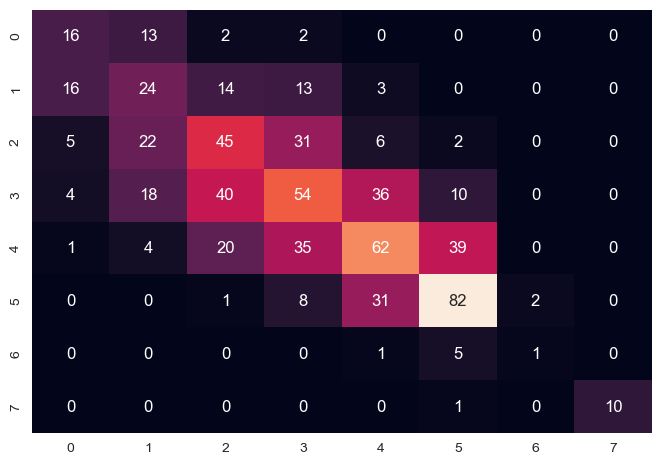

In [52]:
gen_class_report(model, "Random Forest", "", "", X_test, y_test, val_skip=True)

**Comment on Model Performance**

- Model performance coming out is not too great because of highly unbalanced classes. But definately an improvement after oversampling the data.

- Our Model performed poorly to predict a player from league 7 as we have minimal data to train.

- Our model is able to predict the players from top league i.e. league 8 efficiently.

- Model is also getting confused in predicting players accurately from league 1, 2, 3 because of there similar feature values i.e. playing style and attributes as we can observe in our EDA section

# Model Explainability using SHAP

In [53]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

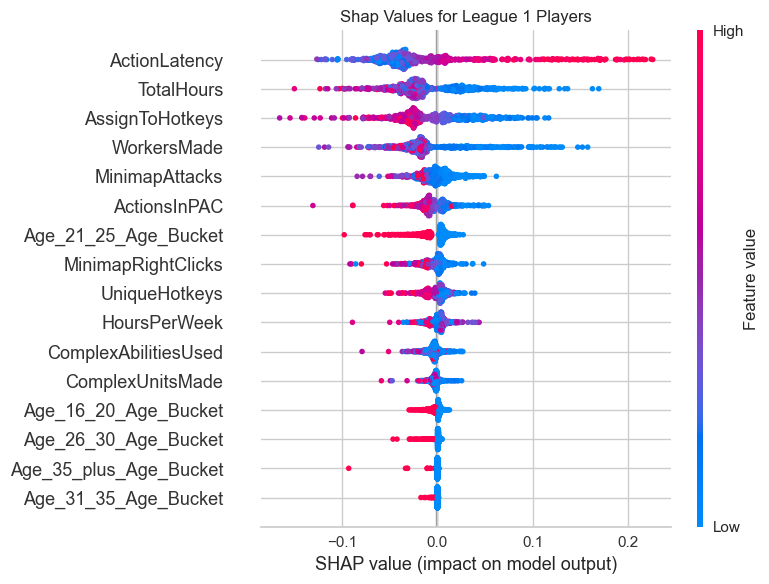

In [54]:
plt.title("Shap Values for League 1 Players")
shap.summary_plot(
    shap_values[0],
    X_test.values,
    feature_names=X_test.columns,
    show=False,
    plot_size=(8, 6),
)

**Shap Value for a top league person**

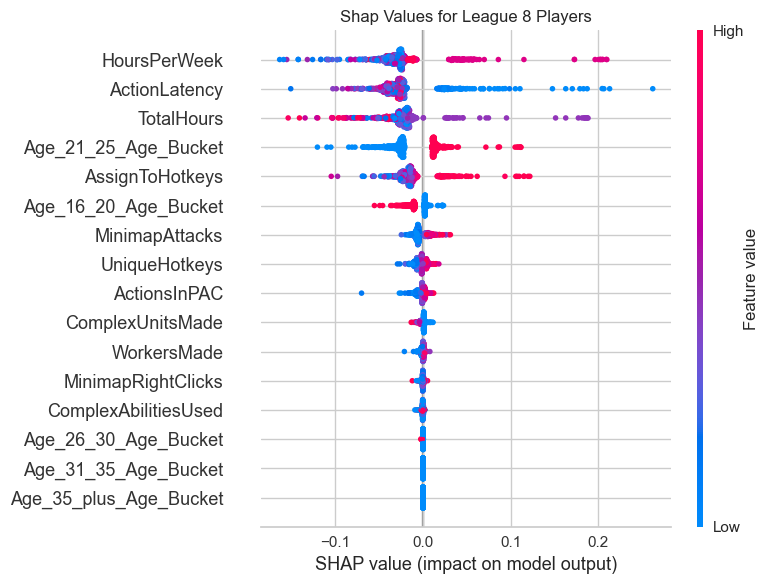

In [55]:
plt.title("Shap Values for League 8 Players")
shap.summary_plot(
    shap_values[7],
    X_test.values,
    feature_names=X_test.columns,
    show=False,
    plot_size=(8, 6),
)

# Insights from Model

**Takeaway from Model**

- We can clearly see action latency to be most important feature the model is using to distinguising a person into different leagues
- Hours per week is an important feature for person who is in top of the league. We can clearly see the boundry and hour hours per week is a big deal for person who is predicted in higher leagues
- Age_21_25 bucket is considered as an important feature by model in predicting the players in top league. It is like a deal breaker in terms of Age. It kind of makes sense that you are still young with some experience might push your limits to outperform other players.
- Similarly high minimap attacks and AssignToHotKeys also pushes players to be in the top league

**Extra Insights Consolidated - Check EDA**

- The widening of distribution functions for higher leagues applies to all roughly to all the features. As you move to higher leagues you find more diversity of players, while for lower leagues most players fall within a narrower band, they are all 'equally' bad.

- Distribution plots for Minimap Attacks, Select By Hotkeys, Assing To Hotkeys, Workers Made, are similar to APMs. They are probably indicative of important features for determining League placement.

- Hours per week is similar to the features above, but with much smaller incremental value except for the top leagues. Complex Abilities Used show much less clear league progression than the others, the league averages are increasing a lot less than the widths of their bell shapes.

- We can see that players with higher number of units or buildings assigned to hotkeys per timestamp and lower action latency seems to perform better and belong to higer leagues and vice versa. Hence this features are important predictors.

**Additional Data that might help**

- There is one more aspect which is out of scope of the data that is given to us i.e. the game synergy between team members. It is possible that a player is very good as an individual but might not perform well in a team. That is good thing to check if data is available and might help in model improvement.


# Conclusion and Scope of Improvement

- We can see that due to high data imblance we are getting a decent baseline model however not a great model. Major reason is the availability of sufficient data for each class. If we can get more data our model can improve seeing more trends nuiances.
- Also for higher league players if we can gather more data then our model can predict league 7 more accurately.
- Some feature engineering was tried but performance degraded, and the features didnt add value to model. The notebook can be check in main_with_feateng.ipynb under code archive.
- Due to compute restrictions SHAP, I was not able able to use it at full potential. We can look at partial dependence plot, local explainability to understand what drives a player in a respective league.